- #!pip3 install tensorflow

- #!pip3 install tensorflow-datasets

- #!pip3 install tensorflow-macos tensorflow-metal 

# Import Required Libraries

In [2]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice

# packaging libraries?
import pickle
from tqdm.notebook import tqdm

# keras libraries

# Image supported libraries
import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_hub as hub
from tensorflow.keras.applications.vgg16 import (VGG16, 
                                                 preprocess_input)
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array)

# Text supported libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model libraries
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import  (Input, 
                                      Dense, 
                                      LSTM, 
                                      Embedding,
                                      Dropout, 
                                      add)

/Users/kavisanthoshkumar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# "1" means GPUs are available to run

Num GPUs Available: 1


# Importing Yaml files

In [4]:
import yaml

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

print(config)

{'INPUT': {'CAPTIONS_FILENAME': '/Users/kavisanthoshkumar/Downloads/Flickr8k_text/Flickr8k.txt', 'IMAGE_FILENAME': '/Users/kavisanthoshkumar/Downloads/Flicker8k_Dataset'}, 'ARTIFACTS': {'IMAGE_FEATURES_DIR': './artifacts/feature.pkl'}}


# Read and Prepare Datasets

We will use the TensorFlow datasets capability to read the COCO captions dataset. This version contains images, bounding boxes, labels, and captions from COCO 2014, split into the subsets defined by Karpathy and Li (2015) and takes care of some data quality issues with the original dataset (for example, some of the images in the original dataset did not have captions)


First, let's define some constants.
Here, we will use a pretrained InceptionResNetV2 model from tf.keras.applications as a feature extractor, so some constants are comming from the InceptionResNetV2 model definition.

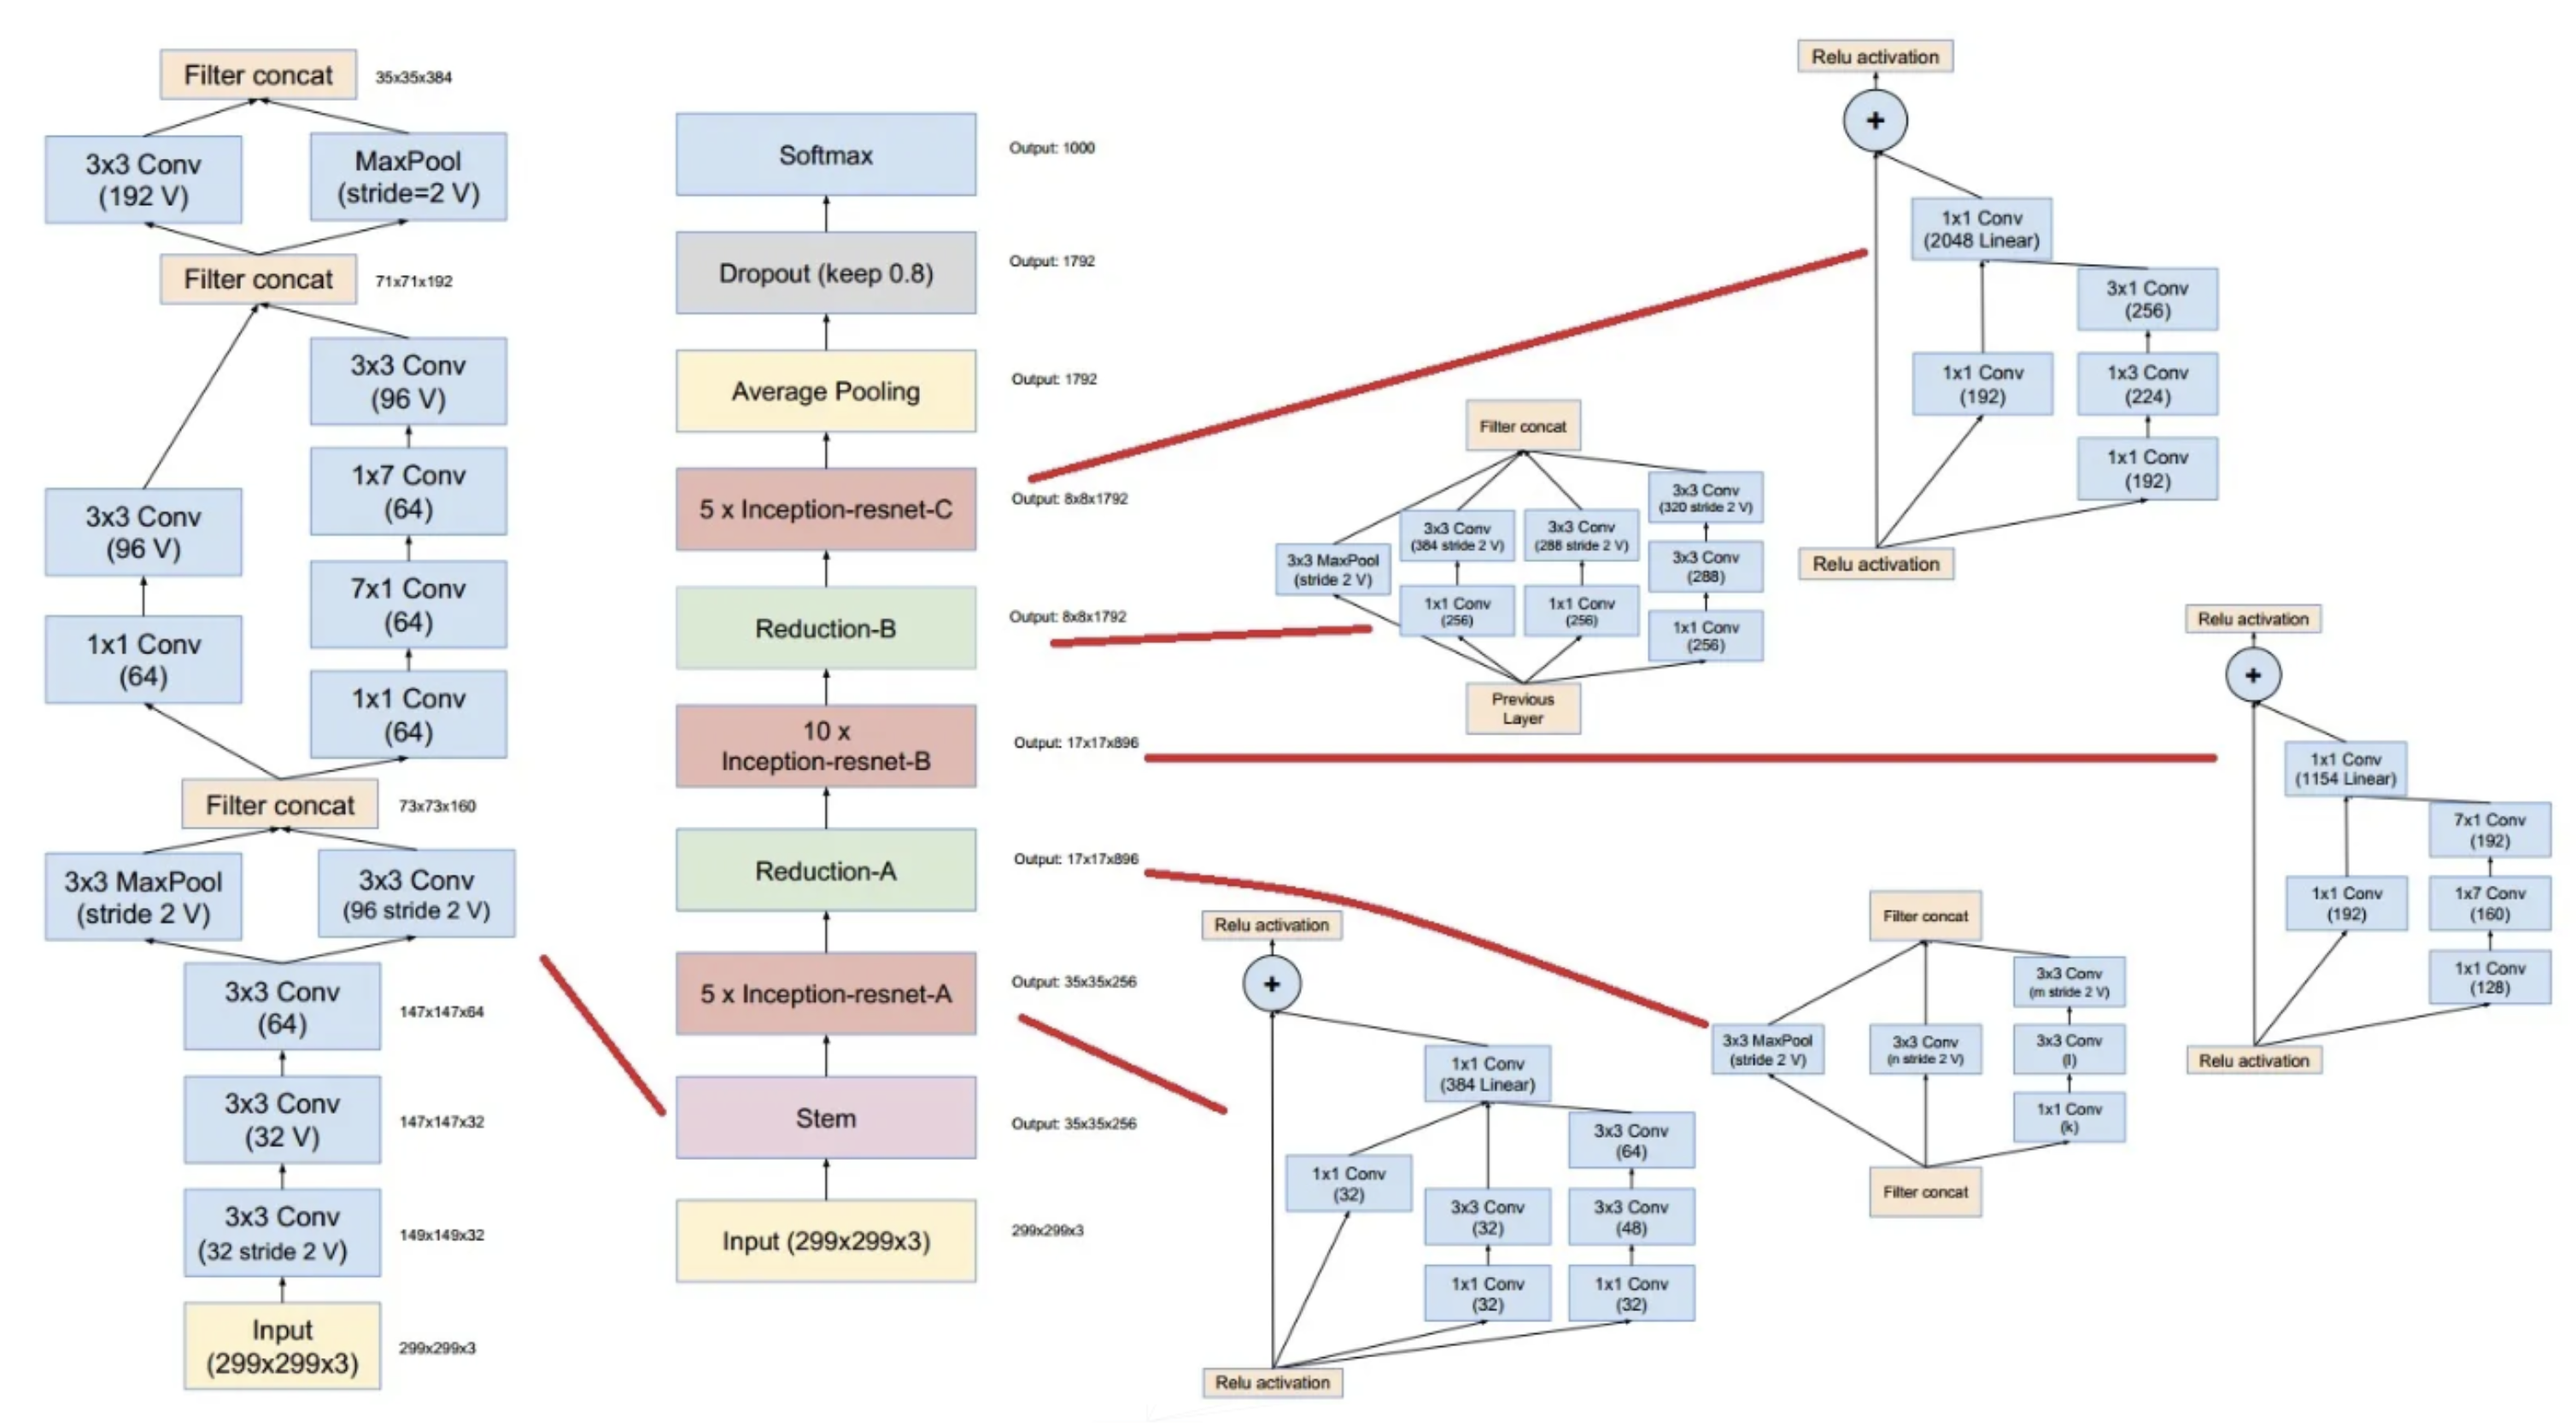

# Image Features

In [5]:
# Load VGG16 model
model = VGG16()

# Restructuring the model - because we don't need the last two layers 
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

# model.input gives the shape of the Image Dataset
# model.layers gives the list, contains the description of each layer and return output of that layer

print(model.summary())


IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3


2025-03-03 14:35:47.838382: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-03 14:35:47.838416: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-03 14:35:47.838422: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1741034147.838637 1023731 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741034147.838821 1023731 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### 1. Extract Features from the Images

Here we preprocess the dataset. The function below

* resize image to (IMG_HEIGHT, IMG_WIDTH) shape
* rescale pixel values from [0, 255] to [0,1]
* return image (image tensor) and (captions) dictionary


The dataset we are going to use hosted in GCS bucket, as it large to store in the local system

In [ ]:
features = {}
directory = config["INPUT"]["IMAGE_FILENAME"]

for img_name in tqdm(os.listdir(directory)):

    # Image Path
    image_path = config["INPUT"]["IMAGE_FILENAME"]+ "/" + img_name

    # load the image from file
    img = load_img(image_path, target_size= (224, 224, 3))

    # Convert Img to Numpy Array
    img = img_to_array(img)

    # Reshape Image
    img = img.reshape((1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

    # Preprocessing image 
    img = preprocess_input(img)

    # generate the feature from the image
    img_features = model.predict(img, verbose=0) # when verbose =0 No output is shown 

    # get the image_id
    image_id = img_name.split(".")[0]

    # save img features with respect to their img id
    features[image_id] = img_features

In [8]:
# store features in pickle
with open(config["ARTIFACTS"]["IMAGE_FEATURES_DIR"], "wb") as file:
    pickle.dump(features,  file)

In [8]:
with open(config["ARTIFACTS"]["IMAGE_FEATURES_DIR"], "rb") as file:
    features = pickle.load(file)

# make sure you have features for the all the input images
directory = config["INPUT"]["IMAGE_FILENAME"]
assert(len(features) == len(os.listdir(directory)))

# 2. Load the Captions Data 

In [9]:
with open(config["INPUT"]["CAPTIONS_FILENAME"], "r") as file:
    captions = file.read()

print(captions[0:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [10]:
# Preprocessing Text file
mapping = {}
captions_list = captions.split('\n')
for caption in tqdm(captions_list):
    # split the line by space
    tokens = caption.split('\t')
    
    # check if the length of caption is less than 2 that means something with the data
    if len(caption) < 2:
        continue

    image_id, caption = tokens[0], tokens[1]

    # remove extension from the image_id
    image_id = image_id.split(".")[0]

    if image_id not in mapping:
        mapping[image_id] = [caption]
    else:
        mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [11]:
# Basic Preprocessing 
def text_preprocessing(mapping: dict) -> dict:

    for key, captions in mapping.items():

        for i in range(0, len(captions)):
            # taking each caption at a time
            caption = captions[i]

            # convert everything to lower
            caption = caption.lower()

            # delete digits, special chars etc..,
            caption = caption.replace('[^A-Za-z]', "")

            # delete additional spaces
            caption = caption.replace("\s+", "")
            
            # Adding start and end tags to the caption
            caption = "start_tag " + " ".join([word for word in caption.split(" ") if len(word) > 1]) + " end_tag"

            captions[i] = caption

In [12]:
text_preprocessing(mapping)

### 2.1 Tokenization

In [13]:
def get_vocab_size(mapping: dict):
    " Get the maximum vocabulary size across all the captions"
    all_captions = []
    for key in mapping.keys():
        for caption in mapping[key]:
            all_captions.append(caption)


    # WhiteSpaceTokenizer  - default tokenizer that keras uses 
    #tokenize = tf_text.WhitespaceTokenizer()
    tokenizer = Tokenizer(num_words=None,       # Maximum number of words to keep (based on frequency)
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  # Characters to filter out
                          lower=True,          # Convert text to lowercase
                          split=' ',           # Separator for splitting text
                          char_level=False,    # If True, tokenize at character level
                          oov_token=None       # Token to use for out-of-vocabulary words (e.g., "<OOV>")
                        )
    tokenizer.fit_on_texts(all_captions)
    
    return all_captions, tokenizer


all_captions, tokenizer = get_vocab_size(mapping)
print(f"Total number of captions across entire captions dataset : {len(all_captions)}")
print(f"Total length of Tokenized words : {len(tokenizer.word_index)}")

# Vocabulary 
vocabulary_lst = [word for word in tokenizer.word_index.keys()]
print(f"len of vocabulary: {len(vocabulary_lst)}")

Total number of captions across entire captions dataset : 40460
Total length of Tokenized words : 8482
len of vocabulary: 8482


### 2.2 Find the length of maximum caption length

In [14]:
max_len = max([len(captions.split(" ")) for captions in all_captions])
print(f"Maximum length of caption (words): {max_len}")

Maximum length of caption (words): 34


# 3 Train Test Split 

In [15]:
image_id = list(mapping.keys())
image_id.remove("2258277193_586949ec62")
split_id  = int(len(image_id) * 0.90)
print(f"Train Test Split Ratio : {split_id}")

train = image_id[:split_id]
test = image_id[split_id:]
print(f"Total number of images consider for training data: {len(train)}")
print(f"Total number of images consider for testing data: {len(test)}")

Train Test Split Ratio : 7281
Total number of images consider for training data: 7281
Total number of images consider for testing data: 810


# 4. DataGenerator

In [16]:
class DataGenerator:

    def __init__(self, features, captions, tokenize_mdl, batch_size, vocabulary_lst, max_len, image_ids):
        """
            Constructor
        """
        self.features = features
        self.captions = captions
        self.batch_size = batch_size
        self.vocabulary_lst = vocabulary_lst
        self.max_len = max_len
        self.image_ids = image_ids
        self.tokenize_mdl = tokenize_mdl

    def generator(self):
        X1, X2, y = list(), list(), list()
        n = 0

        for image_id in self.image_ids:
            n += 1
            for caption in self.captions[image_id]:

                seq = self.tokenize_mdl.texts_to_sequences([caption])[0] # Converts the text into some sort of sequence of numbers

                for i in range(1, len(seq)):

                    # creating chain of input sequence and output sequence
                    in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = self.max_len)[0]

                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes= len(self.vocabulary_lst))[0]

                    # store the sequence
                    X1.append(self.features[image_id][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                
            if n == self.batch_size:
                
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield ((X1, X2), y)

                # set to original 
                X1, X2, y = list(), list(), list()
                n = 0


In [17]:
data_gen = DataGenerator(features=features, # Image features
              captions=mapping, # Captions
              tokenize_mdl=tokenizer, # Converts text to Sequences
              batch_size = 1, # How many samples are combined as batch
              vocabulary_lst= vocabulary_lst, # num of classes
              max_len = max_len, # used to padding the sequence
              image_ids = image_id[0:1] # only train image_ids are passed
              )

# 5. Model Creation

In [18]:
# Encoder Model
# Image feature layers
input1 = Input(shape = (4096, ))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation = 'relu')(fe1)


# Text feature layers
input2 = Input(shape = (max_len, ))
se1 = Embedding(len(vocabulary_lst), 256, mask_zero = True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)


# Decoder model
decorder1 = add([fe2, se3])
decorder2 = Dense(256, activation = "relu")(decorder1)
outputs = Dense(len(vocabulary_lst), activation = "softmax")(decorder2)


model = Model(inputs = [input1, input2], outputs = outputs)
model.compile(loss = "categorical_crossentropy", optimizer = "adam")


# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,171,392 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8482)      │  2,179,874 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,991,202 (22.85 MB)

 Trainable params: 5,991,202 (22.85 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Training & Saving Model

In [33]:
epochs  = 100
batch_size = 10
steps = len(train) // batch_size

for i in range(epochs):
    # data generator
    generator_data = data_gen = DataGenerator(features=features, # Image features
                        captions=mapping, # Captions
                        tokenize_mdl=tokenizer, # Converts text to Sequences
                        batch_size = batch_size, # How many samples are combined as batch
                        vocabulary_lst= vocabulary_lst, # num of classes
                        max_len = max_len, # used to padding the sequence
                        image_ids = train[0:100] # only train image_ids are passed
              ).generator()
    
    # fit for one epoch
    model.fit(generator_data, epochs = 1, steps_per_epoch= steps, verbose = 1)

728/728 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2403.0173


2025-03-03 15:09:12.565745: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:09:12.565771: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:09:12.565780: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:09:12.565784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5313541772521006682
2025-03-03 15:09:12.565787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:09:12.565790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:09:12.565793: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2133.4365


2025-03-03 15:09:25.958378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:09:25.958392: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:09:25.958395: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:09:25.958400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:09:25.958414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:09:25.958433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:09:25.958442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1815.2786


2025-03-03 15:09:38.825811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:09:38.825826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:09:38.825830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:09:38.825865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:09:38.825870: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:09:38.825873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3723535598107643768
2025-03-03 15:09:38.825876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1642.6804


2025-03-03 15:09:51.961208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:09:51.961222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:09:51.961227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:09:51.961231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:09:51.961238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:09:51.961242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:09:51.961246: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1632.6125


2025-03-03 15:10:04.749073: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:10:04.749124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:10:04.749132: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:10:04.749138: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:10:04.749143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:10:04.749148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:10:04.749154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1643.1456


2025-03-03 15:10:17.448674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:10:17.448685: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:10:17.448690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 158224948273505456
2025-03-03 15:10:17.448701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4593509339961445656
2025-03-03 15:10:17.448703: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:10:17.448712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:10:17.448720: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 1628.7238


2025-03-03 15:10:31.157730: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:10:31.157744: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6326484582467050114
2025-03-03 15:10:31.157748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:10:31.157753: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:10:31.157756: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:10:31.157761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:10:31.157769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 1862.4476


2025-03-03 15:10:44.806268: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:10:44.806280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:10:44.806285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:10:44.806289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:10:44.806294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:10:44.806300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:10:44.806304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 2006.0317


2025-03-03 15:10:58.794251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:10:58.794264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:10:58.794298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:10:58.794302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:10:58.794306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:10:58.794309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:10:58.794313: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2012.2983


2025-03-03 15:11:11.766909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:11:11.766927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:11:11.766932: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:11:11.766936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1830933073534939178
2025-03-03 15:11:11.766939: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:11:11.766956: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:11:11.766960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1928.1556


2025-03-03 15:11:24.632855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:11:24.632870: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:11:24.632874: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:11:24.632877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9802609596227381010
2025-03-03 15:11:24.632881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:11:24.632886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:11:24.632892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1837.2397


2025-03-03 15:11:37.712190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:11:37.712204: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_54]]
2025-03-03 15:11:37.712209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4817111279079998202
2025-03-03 15:11:37.712213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:11:37.712217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:11:37.712221: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:11:37.712225: I tensorflow/co

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1808.0293


2025-03-03 15:11:50.737336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:11:50.737352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:11:50.737356: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:11:50.737361: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:11:50.737367: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4593509339961445656
2025-03-03 15:11:50.737371: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3723535598107643768
2025-03-03 15:11:50.737377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2021.4242


2025-03-03 15:12:03.713448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:12:03.713467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:12:03.713477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:12:03.713484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:12:03.713487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:12:03.713495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14989550864717793110
2025-03-03 15:12:03.713506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2256.2068


2025-03-03 15:12:16.657690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 158224948273505456
2025-03-03 15:12:16.657702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:12:16.657707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:12:16.657710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:12:16.657736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:12:16.657743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10576200871726195715
2025-03-03 15:12:16.657746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2479.7356


2025-03-03 15:12:29.547124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:12:29.547135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:12:29.547139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:12:29.547145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:12:29.547149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:12:29.547155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9802609596227381010
2025-03-03 15:12:29.547160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2548.8384


2025-03-03 15:12:42.799622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:12:42.799649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13645469807490505523
2025-03-03 15:12:42.799658: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:12:42.799662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:12:42.799665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:12:42.799669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8395177798808001645
2025-03-03 15:12:42.799674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 2693.0955


2025-03-03 15:12:56.200493: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:12:56.200505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:12:56.200510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:12:56.200516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:12:56.200520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7875033106594383779
2025-03-03 15:12:56.200523: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3851928254193289621
2025-03-03 15:12:56.200526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 2817.4177


2025-03-03 15:13:09.906833: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:13:09.906852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:13:09.906856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:13:09.906859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1830933073534939178
2025-03-03 15:13:09.906862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:13:09.906865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:13:09.906869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2946.2349


2025-03-03 15:13:23.053114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:13:23.053131: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:13:23.053143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:13:23.053151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:13:23.053154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:13:23.053166: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10045407439763655816
2025-03-03 15:13:23.053178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 2895.1143


2025-03-03 15:13:36.443418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:13:36.443431: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:13:36.443436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:13:36.443440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:13:36.443444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:13:36.443447: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13544564491305875102
2025-03-03 15:13:36.443451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

728/728 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 2819.5654


2025-03-03 15:13:50.024937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16100573376997741460
2025-03-03 15:13:50.024948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10045407439763655816
2025-03-03 15:13:50.024960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13647292142005730198
2025-03-03 15:13:50.024965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:13:50.024969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:13:50.024980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:13:50.024984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2822.5742


2025-03-03 15:14:03.420704: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:14:03.420716: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:14:03.420722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:14:03.420731: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:14:03.420736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:14:03.420739: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:14:03.420743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2912.2380


2025-03-03 15:14:16.451732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:14:16.451747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:14:16.451775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:14:16.451781: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:14:16.451785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:14:16.451789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3851928254193289621
2025-03-03 15:14:16.451791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 2751.9167


2025-03-03 15:14:30.451509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:14:30.451522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:14:30.451529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:14:30.451539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:14:30.451542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10045407439763655816
2025-03-03 15:14:30.451554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:14:30.451558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2522.2463


2025-03-03 15:14:43.405762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:14:43.405779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:14:43.405788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:14:43.405793: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:14:43.405798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8395177798808001645
2025-03-03 15:14:43.405805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:14:43.405809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2331.6350


2025-03-03 15:14:56.029223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:14:56.029233: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:14:56.029243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:14:56.029247: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:14:56.029252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:14:56.029255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:14:56.029258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2318.7180


2025-03-03 15:15:09.239083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:15:09.239097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6326484582467050114
2025-03-03 15:15:09.239114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:15:09.239118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:15:09.239121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:15:09.239124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:15:09.239127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2189.6013


2025-03-03 15:15:22.021996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:15:22.022008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:15:22.022011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:15:22.022014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:15:22.022018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:15:22.022021: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:15:22.022023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 2021.8215


2025-03-03 15:15:34.639497: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:15:34.639512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:15:34.639524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:15:34.639530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:15:34.639537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:15:34.639542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:15:34.639547: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1870.4397


2025-03-03 15:15:47.388315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:15:47.388371: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:15:47.388378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:15:47.388402: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:15:47.388407: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:15:47.388411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:15:47.388415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1697.1490


2025-03-03 15:16:00.788167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:16:00.788180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:16:00.788185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:16:00.788189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1830933073534939178
2025-03-03 15:16:00.788195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:16:00.788199: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5709775249115231644
2025-03-03 15:16:00.788202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1594.6924


2025-03-03 15:16:13.621169: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12446808022654402039
2025-03-03 15:16:13.621187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:16:13.621193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:16:13.621196: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:16:13.621206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:16:13.621209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13503156076864191623
2025-03-03 15:16:13.621213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1520.2566


2025-03-03 15:16:26.552061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5908949851779268574
2025-03-03 15:16:26.552074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:16:26.552077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:16:26.552080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:16:26.552083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:16:26.552094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:16:26.552100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1479.8604


2025-03-03 15:16:39.146810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:16:39.146870: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:16:39.146877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:16:39.146882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:16:39.146885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:16:39.146889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:16:39.146892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 1397.5476


2025-03-03 15:16:51.675193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:16:51.675205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:16:51.675211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:16:51.675217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5313541772521006682
2025-03-03 15:16:51.675220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:16:51.675223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:16:51.675226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 1325.4633


2025-03-03 15:17:04.204139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5895048565637538144
2025-03-03 15:17:04.204171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:17:04.204179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:17:04.204187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:17:04.204190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:17:04.204199: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16100573376997741460
2025-03-03 15:17:04.204201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1251.9067


2025-03-03 15:17:16.852941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:17:16.852956: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3723535598107643768
2025-03-03 15:17:16.852960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:17:16.852964: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:17:16.852967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:17:16.852970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:17:16.852973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1170.9951


2025-03-03 15:17:29.663294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:17:29.663308: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:17:29.663312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:17:29.663317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:17:29.663321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:17:29.663346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:17:29.663353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1092.1010


2025-03-03 15:17:42.494892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12998694913162828236
2025-03-03 15:17:42.494904: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:17:42.494908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:17:42.494913: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:17:42.494915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:17:42.494918: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:17:42.494921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1030.6781


2025-03-03 15:17:55.396198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5908949851779268574
2025-03-03 15:17:55.396218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:17:55.396223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:17:55.396257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:17:55.396264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:17:55.396267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:17:55.396270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 985.3995


2025-03-03 15:18:07.920970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:18:07.920982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16100573376997741460
2025-03-03 15:18:07.920990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:18:07.920993: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13544564491305875102
2025-03-03 15:18:07.920996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:18:07.920998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12998694913162828236
2025-03-03 15:18:07.921001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 938.3575


2025-03-03 15:18:20.526155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:18:20.526169: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:18:20.526175: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:18:20.526179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14989550864717793110
2025-03-03 15:18:20.526183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4817111279079998202
2025-03-03 15:18:20.526187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:18:20.526197: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 901.1766


2025-03-03 15:18:33.078404: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:18:33.078421: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:18:33.078425: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:18:33.078428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5313541772521006682
2025-03-03 15:18:33.078431: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:18:33.078434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:18:33.078436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 853.7822


2025-03-03 15:18:45.656251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:18:45.656263: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:18:45.656287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:18:45.656296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:18:45.656301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:18:45.656306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:18:45.656316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 788.1368


2025-03-03 15:18:58.386430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:18:58.386471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:18:58.386476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5709775249115231644
2025-03-03 15:18:58.386481: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:18:58.386485: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:18:58.386488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:18:58.386491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 746.0189


2025-03-03 15:19:11.075440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:19:11.075452: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:19:11.075456: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:19:11.075459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:19:11.075470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:19:11.075473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13503156076864191623
2025-03-03 15:19:11.075476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 720.6220


2025-03-03 15:19:23.809159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10681991366756610110
2025-03-03 15:19:23.809175: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16100573376997741460
2025-03-03 15:19:23.809182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:19:23.809186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:19:23.809190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13544564491305875102
2025-03-03 15:19:23.809198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12998694913162828236
2025-03-03 15:19:23.809202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 712.4941


2025-03-03 15:19:36.469108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:19:36.469124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1893359009097902896
2025-03-03 15:19:36.469132: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:19:36.469135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:19:36.469141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:19:36.469144: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:19:36.469151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 688.5466


2025-03-03 15:19:49.196040: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:19:49.196053: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:19:49.196107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:19:49.196115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:19:49.196123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:19:49.196129: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:19:49.196139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 653.4822


2025-03-03 15:20:01.698039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:20:01.698054: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:20:01.698059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:20:01.698069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:20:01.698071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:20:01.698078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4817111279079998202
2025-03-03 15:20:01.698083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 615.1108


2025-03-03 15:20:14.188319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:20:14.188331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:20:14.188342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12173788261506678095
2025-03-03 15:20:14.188345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:20:14.188350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:20:14.188353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:20:14.188356: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 589.7788


2025-03-03 15:20:26.786760: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5908949851779268574
2025-03-03 15:20:26.786772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:20:26.786778: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:20:26.786781: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:20:26.786785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5313541772521006682
2025-03-03 15:20:26.786789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:20:26.786797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 566.4235


2025-03-03 15:20:39.385673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:20:39.385688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:20:39.385692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:20:39.385695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:20:39.385698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:20:39.385701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:20:39.385704: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 561.9769


2025-03-03 15:20:52.064606: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:20:52.064618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:20:52.064627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:20:52.064631: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:20:52.064638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:20:52.064648: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:20:52.064651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 560.1269


2025-03-03 15:21:04.671806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:21:04.671818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:21:04.671821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:21:04.671825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:21:04.671827: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:21:04.671831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:21:04.671834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 530.0323


2025-03-03 15:21:17.171659: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:21:17.171671: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:21:17.171675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:21:17.171678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:21:17.171680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:21:17.171683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10045407439763655816
2025-03-03 15:21:17.171696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 527.7686


2025-03-03 15:21:29.708727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:21:29.708740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:21:29.708744: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:21:29.708747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:21:29.708750: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3723535598107643768
2025-03-03 15:21:29.708753: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:21:29.708757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 530.5663


2025-03-03 15:21:42.209921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:21:42.209971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:21:42.209980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:21:42.209984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:21:42.209989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:21:42.209991: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:21:42.209994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 517.1196


2025-03-03 15:21:54.749672: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:21:54.749688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:21:54.749693: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:21:54.749696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:21:54.749699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:21:54.749702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:21:54.749705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 483.1222


2025-03-03 15:22:07.311950: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:22:07.311962: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:22:07.311966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:22:07.311969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:22:07.311979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3851928254193289621
2025-03-03 15:22:07.311985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8425062760608027663
2025-03-03 15:22:07.311989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 463.8477


2025-03-03 15:22:19.789820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:22:19.789834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:22:19.789907: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:22:19.789914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:22:19.789919: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:22:19.789922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:22:19.789926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 188s 16ms/step - loss: 448.1507


2025-03-03 15:25:27.576254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:25:27.576265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:25:27.576273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 158224948273505456
2025-03-03 15:25:27.576276: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:25:27.576286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5908949851779268574
2025-03-03 15:25:27.576291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:25:27.576294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 423.7483


2025-03-03 15:25:39.985237: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:25:39.985248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:25:39.985252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:25:39.985264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:25:39.985275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:25:39.985279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3851928254193289621
2025-03-03 15:25:39.985282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 414.1172


2025-03-03 15:25:52.434080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:25:52.434094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:25:52.434098: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:25:52.434101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:25:52.434103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17268071340342223549
2025-03-03 15:25:52.434106: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13503156076864191623
2025-03-03 15:25:52.434109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 404.1105


2025-03-03 15:26:04.979947: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:26:04.979990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:26:04.979998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:26:04.980003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:26:04.980007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:26:04.980010: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3851928254193289621
2025-03-03 15:26:04.980014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 413.8467


2025-03-03 15:26:17.503985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:26:17.504001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:26:17.504005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:26:17.504008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5313541772521006682
2025-03-03 15:26:17.504011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:26:17.504013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:26:17.504016: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 389.8958


2025-03-03 15:26:29.927632: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:26:29.927652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:26:29.927659: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:26:29.927669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:26:29.927676: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:26:29.927682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:26:29.927688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 365.0865


2025-03-03 15:26:42.419065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5908949851779268574
2025-03-03 15:26:42.419109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:26:42.419122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:26:42.419130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:26:42.419135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:26:42.419143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:26:42.419152: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 372.5483


2025-03-03 15:26:54.896673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:26:54.896687: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:26:54.896691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:26:54.896695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:26:54.896698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:26:54.896710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:26:54.896719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 356.2271


2025-03-03 15:27:07.352624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:27:07.352635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:27:07.352644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:27:07.352647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:27:07.352650: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:27:07.352654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:27:07.352656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 365.0770


2025-03-03 15:27:19.833057: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:27:19.833072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:27:19.833078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:27:19.833081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:27:19.833084: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:27:19.833088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:27:19.833091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 373.3281


2025-03-03 15:27:32.337710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:27:32.337721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6326484582467050114
2025-03-03 15:27:32.337725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:27:32.337729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:27:32.337732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:27:32.337735: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:27:32.337738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 387.4393


2025-03-03 15:27:44.818676: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:27:44.818694: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:27:44.818698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:27:44.818701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:27:44.818704: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:27:44.818707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8425062760608027663
2025-03-03 15:27:44.818709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 384.6118


2025-03-03 15:27:57.382508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:27:57.382522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:27:57.382527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:27:57.382530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:27:57.382539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:27:57.382549: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:27:57.382552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 372.0598


2025-03-03 15:28:09.924623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 889103459776823071
2025-03-03 15:28:09.924647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16439690770574147663
2025-03-03 15:28:09.924655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:28:09.924663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16864281689759646783
2025-03-03 15:28:09.924671: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4749087681131153603
2025-03-03 15:28:09.924677: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17761878731868702831
2025-03-03 15:28:09.924684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 356.7282


2025-03-03 15:28:22.535154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:28:22.535166: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3723535598107643768
2025-03-03 15:28:22.535171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:28:22.535173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:28:22.535176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:28:22.535179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:28:22.535182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 341.3416


2025-03-03 15:28:35.074506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:28:35.074557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14989550864717793110
2025-03-03 15:28:35.074564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:28:35.074568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:28:35.074571: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:28:35.074575: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9246482987279828383
2025-03-03 15:28:35.074578: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 344.2252


2025-03-03 15:28:47.778094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:28:47.778107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1830933073534939178
2025-03-03 15:28:47.778112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:28:47.778119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:28:47.778122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13544564491305875102
2025-03-03 15:28:47.778126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:28:47.778136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 348.0407


2025-03-03 15:29:00.253429: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:29:00.253442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8395177798808001645
2025-03-03 15:29:00.253447: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:29:00.253455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:29:00.253459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14957411642965254667
2025-03-03 15:29:00.253462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7476518635061812463
2025-03-03 15:29:00.253465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 348.4664


2025-03-03 15:29:12.709684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:29:12.709698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:29:12.709702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:29:12.709705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:29:12.709708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:29:12.709711: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9802609596227381010
2025-03-03 15:29:12.709714: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 369.0652


2025-03-03 15:29:25.226616: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 158224948273505456
2025-03-03 15:29:25.226631: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:29:25.226677: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:29:25.226686: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:29:25.226691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:29:25.226696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:29:25.226699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 378.4303


2025-03-03 15:29:37.728935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:29:37.728948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:29:37.728960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:29:37.728970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:29:37.728972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:29:37.728980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:29:37.728984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 386.0682


2025-03-03 15:29:50.244602: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:29:50.244621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:29:50.244635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:29:50.244638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:29:50.244642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5313541772521006682
2025-03-03 15:29:50.244645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:29:50.244647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 395.4439


2025-03-03 15:30:02.717547: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 158224948273505456
2025-03-03 15:30:02.717585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:30:02.717594: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:30:02.717599: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:30:02.717602: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:30:02.717606: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3790258016341976456
2025-03-03 15:30:02.717609: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 382.1008


2025-03-03 15:30:15.195514: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:30:15.195529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:30:15.195535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:30:15.195538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:30:15.195540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:30:15.195551: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:30:15.195558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 358.5475


2025-03-03 15:30:27.621621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:30:27.621639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:30:27.621642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:30:27.621645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:30:27.621690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:30:27.621704: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:30:27.621708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 326.8592


2025-03-03 15:30:40.216110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:30:40.216123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:30:40.216128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:30:40.216131: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:30:40.216134: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:30:40.216137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7875033106594383779
2025-03-03 15:30:40.216140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 341.3845


2025-03-03 15:30:52.842457: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:30:52.842471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:30:52.842476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:30:52.842480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:30:52.842484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14989550864717793110
2025-03-03 15:30:52.842487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:30:52.842491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 352.8226


2025-03-03 15:31:05.265080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 158224948273505456
2025-03-03 15:31:05.265111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:31:05.265155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:31:05.265176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:31:05.265182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:31:05.265187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:31:05.265195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 346.8422


2025-03-03 15:31:17.738246: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:31:17.738276: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:31:17.738280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:31:17.738283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:31:17.738286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 140897329932446050
2025-03-03 15:31:17.738289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6200080271054391994
2025-03-03 15:31:17.738292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 345.0825


2025-03-03 15:31:30.226167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:31:30.226182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:31:30.226186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:31:30.226189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:31:30.226193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:31:30.226197: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14351366984507328367
2025-03-03 15:31:30.226200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 361.1097


2025-03-03 15:31:43.283607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:31:43.283624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16100573376997741460
2025-03-03 15:31:43.283629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:31:43.283635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12173788261506678095
2025-03-03 15:31:43.283638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8395177798808001645
2025-03-03 15:31:43.283640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:31:43.283643: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 347.9847


2025-03-03 15:31:55.729419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:31:55.729432: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:31:55.729435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1624736448010076629
2025-03-03 15:31:55.729442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:31:55.729446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:31:55.729455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:31:55.729462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 341.1489


2025-03-03 15:32:08.291630: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:32:08.291643: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:32:08.291647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:32:08.291652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5313541772521006682
2025-03-03 15:32:08.291656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10939313590298403964
2025-03-03 15:32:08.291659: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18424245844380968912
2025-03-03 15:32:08.291662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 352.3168


2025-03-03 15:32:20.788983: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5908949851779268574
2025-03-03 15:32:20.788997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:32:20.789005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5704111110749175781
2025-03-03 15:32:20.789010: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:32:20.789015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:32:20.789018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:32:20.789037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 361.0904


2025-03-03 15:32:33.358269: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:32:33.358281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:32:33.358286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:32:33.358289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:32:33.358295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:32:33.358301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:32:33.358312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 358.0163


2025-03-03 15:32:46.402960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:32:46.402971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6636753630753301672
2025-03-03 15:32:46.402975: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7086002556110955658
2025-03-03 15:32:46.402978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:32:46.402981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:32:46.403006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 813748966325462184
2025-03-03 15:32:46.403018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

728/728 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 331.6451


2025-03-03 15:32:59.024786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:32:59.024800: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4593509339961445656
2025-03-03 15:32:59.024804: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12261850444141821735
2025-03-03 15:32:59.024807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3699297544634958773
2025-03-03 15:32:59.024810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5682266485491188963
2025-03-03 15:32:59.024813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9013213846731359583
2025-03-03 15:32:59.024816: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

728/728 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 330.1060


2025-03-03 15:33:11.513331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11832708817888166434
2025-03-03 15:33:11.513344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17049435746220343948
2025-03-03 15:33:11.513352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7981357387576558870
2025-03-03 15:33:11.513357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5497825051083704174
2025-03-03 15:33:11.513360: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17278392414017999030
2025-03-03 15:33:11.513363: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16100573376997741460
2025-03-03 15:33:11.513366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

In [34]:
model.save("./artifacts/encoder_decoder_model.keras")

# Generate Captions for the Image

In [35]:
# Here we are returing the word based on the integer generated by our model
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
        
# Generate captions for the image
def getPrediction(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start_tag'

    # iterate over the max length of sequence
    for i in range(max_length):

        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # pad the sequence
        sequence = pad_sequences([sequence], max_length)

        #print(f"Shape of Image: {image.shape}, Sequence: {sequence.shape}, {(image, sequence)}")
        # predict using trained model
        yhat = model.predict((image, sequence), verbose = 0)

        # get the index with high probability
        yhat = np.argmax(yhat)

        # convert index to word
        word = idx_to_word(yhat, tokenizer)

        # stop if word not found
        if word is None:
            break

        # append word as input for generating next word
        in_text = in_text + " " + word

        # stop word if we see end_tag
        if word == "end_tag":
            break


    return in_text        

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]

    # predict caption using the model
    y_pred = getPrediction(model, features[key], tokenizer, max_len)

    # split the words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # append to the list
    actual.append(actual_captions)
    y_pred.append(y_pred)

# Visualize the Results

================== Original Captions =================
start_tag child in pink dress is climbing up set of stairs in an entry way end_tag
start_tag girl going into wooden building end_tag
start_tag little girl climbing into wooden playhouse end_tag
start_tag little girl climbing the stairs to her playhouse end_tag
start_tag little girl in pink dress going into wooden cabin end_tag
======Prediction=====
start_tag end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end


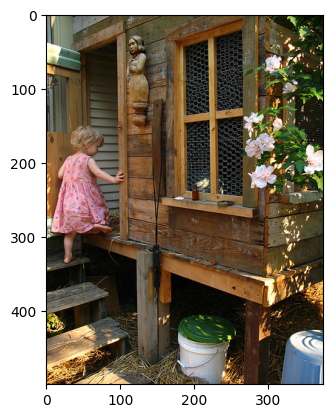

In [38]:
from PIL import Image
import matplotlib.pyplot as plt

image_name = "1000268201_693b08cb0e.jpg"
image_id_vis = image_name.split(".")[0] # to get the caption related to the image

# Load the Image
image_path = os.path.join(config["INPUT"]["IMAGE_FILENAME"], image_name)
image = Image.open(image_path)

# Original Caption
captions = mapping[image_id_vis]
print("================== Original Captions =================")
for caption in captions:
    print(caption)

y_pred = getPrediction(model, features[image_id_vis], tokenizer, max_len)

plt.imshow(image)

print("======Prediction=====")
print(y_pred)

